In [329]:
import numpy as np
import pandas as pd
from pandas import Series
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('seaborn')
sns.set(font_scale=2.5) 

해당하는 두 줄은 matplotlib 의 기본 scheme 말고 seaborn scheme 을 세팅하고,
일일이 graph 의 font size 를 지정할 필요 없이 seaborn 의 font_scale 을 사용하게 해주는 설정입니다.

In [330]:
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls

import warnings
warnings.filterwarnings('ignore')

경고를 무시하는 설정입니다.

In [331]:
%matplotlib inline

df_train = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')
df_train['FamilySize'] = df_train['SibSp'] + df_train['Parch']+1
df_test['FamilySize'] = df_test['SibSp'] + df_test['Parch']+1

자기자신을 포함해야 하니 1을 더해주는 모습입니다.

In [332]:
df_train['Fare'] = df_train['Fare'].map(lambda i: np.log(i) if i > 0 else 0)
df_test['Fare'] = df_test['Fare'].map(lambda i: np.log(i) if i > 0 else 0)

<h1> Feature engineering </h1>
   -본격적인 feature engineering을 시작해보겟습니다.<br><br>
   -가장 먼저, dataset 에 존재하는 null data를 채우려고 합니다.
      아무 숫자로 채울 수는 없고,  <br>  null data를 포함하는 feature의 staistics를 참고하거나
      다른 아이디어를 짜내어 채울 수 있습니다.<br><br>
   -null data를 어떻게 채우느냐에 따라 모델의 성능이 좌지우지될 수 있기 때문에, 신경써줘야할 부분입니다.<br><br>
   -Feature engineering 은 실제 모델 학습에 쓰려고 하는 것이므로, train 뿐만아니라 test도 똑같이 적용해야합니다. 잊지마세요

<h2> 3.1 Fill Null </h2><br><br>
<h3> 3.1.1 Fill Null in Age using title </h3><br>
 -Age 에는 null data가 177개나 있습니다. 이를 채울 수 있는 여러 아이디어가 있을 것인데, 여기서 우리는 title+statistics 를 사용해보겠습니다 <br>
 -영어에서는 Miss,Mrr,Mrs 같은 title이 존재합니다. 각 탑승객의 이름에는 꼭 이런 title이 들어가게 되는데, 이를 사용해보겠습니다<br>
 -pandas series 에는 data를 string 으로 바꿔주는 str method, 거기에 정규표현식을 적용하게 해주는 extract method가 있습니다. 이를 사용하여 title을 쉽게 추출할 수 있습니다. title을 initial column에 저장하겠습니다

In [333]:
df_train['Initial']= df_train.Name.str.extract('([A-Za-z]+)\.') 
#Lets extract the Salutations

In [334]:
df_test['Initial']=df_test.Name.str.extract('([A-Za-z]+)\n.')
#lets extract the Salutations

In [335]:
pd.crosstab(df_train['Initial'], df_train['Sex']).T.style.background_gradient(cmap='summer_r')
#Checking the Initials with the Sex

Initial,Capt,Col,Countess,Don,Dr,Jonkheer,Lady,Major,Master,Miss,Mlle,Mme,Mr,Mrs,Ms,Rev,Sir
Sex,,,,,,,,,,,,,,,,,
female,0,0,1,0,1,0,1,0,0,182,2,1,0,125,1,0,0
male,1,2,0,1,6,1,0,2,40,0,0,0,517,0,0,6,1


- 위 table 을 참고하여, 남자, 여자가 쓰는 initial을 구분해 보겠습니다. replace 메소드를 사용하면, 특정 데이터 값을 원하는 값으로 치환해해줍니다.

In [336]:
df_train['Initial'].replace(['Mile','Mme','Ms','Dr','Major','Lady','Countess','Jonkheer','Col','Rev','Capt','Sir','Don','Dona'],
                           ['Miss','Miss','Miss','Mr','Mr','Mrs','Mrs','Other','Other','Other','Mr','Mr','Mr','Mr'],inplace= True)
df_test['Initial'].replace(['Mile','Mme','Ms','Dr','Major','Lady','Countess','Jonkheer','Col','Rev','Capt','Sir','Don','Dona'],
                           ['Miss','Miss','Miss','Mr','Mr','Mrs','Mrs','Other','Other','Other','Mr','Mr','Mr','Mr'],inplace= True)


In [337]:
df_train.groupby('Initial').mean()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare,FamilySize
Initial,,,,,,,,
Master,414.975000,0.575000,2.625000,4.574167,2.300000,1.375000,3.340710,4.675000
Miss,408.864130,0.701087,2.298913,21.831081,0.706522,0.543478,3.113425,2.250000
Mlle,676.500000,1.000000,1.000000,24.000000,0.000000,0.000000,4.070251,1.000000
Mr,455.880907,0.162571,2.381853,32.739609,0.293006,0.151229,2.651507,1.444234
Mrs,456.393701,0.795276,1.984252,35.981818,0.692913,0.818898,3.443751,2.511811
Other,564.444444,0.111111,1.666667,45.888889,0.111111,0.111111,2.641605,1.222222


 - 여성과 관계 있는 Miss, Mr, Mrs가 생존률이 높은 것을 볼 수 있습니다.

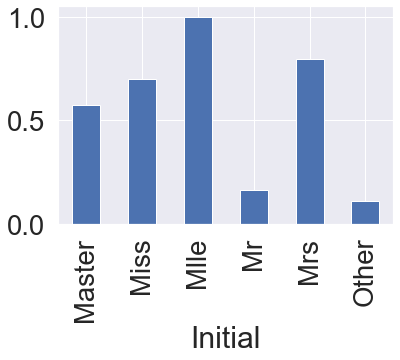

In [338]:
df_train.groupby('Initial')['Survived'].mean().plot.bar()

 - 이제 본격적으로 Null 을 채울 것입니다. null data를 채우는 방법은 다수가 있습니다. statistics를 활용하는 방법도 있고, null data가 없는 데이터를 기반으로 새로운 머신러닝 알고리즘을 만들어 예측해서 채워넣는 방식도 있습니다. 여기서는 statistics를 활용하는 방법을 사용할 것입니다. <br>
 - 여기서 statistics 는 train data 의 것을 의미합니다. 우리는 언제나 test를 unseen 으로 둔 상태로 놔둬야 하며, train 에서 얻은 statistics 를 기반으로 test의 null data를 채워줘야 합니다.

In [339]:
df_train.groupby('Initial').mean()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare,FamilySize
Initial,,,,,,,,
Master,414.975000,0.575000,2.625000,4.574167,2.300000,1.375000,3.340710,4.675000
Miss,408.864130,0.701087,2.298913,21.831081,0.706522,0.543478,3.113425,2.250000
Mlle,676.500000,1.000000,1.000000,24.000000,0.000000,0.000000,4.070251,1.000000
Mr,455.880907,0.162571,2.381853,32.739609,0.293006,0.151229,2.651507,1.444234
Mrs,456.393701,0.795276,1.984252,35.981818,0.692913,0.818898,3.443751,2.511811
Other,564.444444,0.111111,1.666667,45.888889,0.111111,0.111111,2.641605,1.222222


 - Age의 평균을 이용해 Null value 를 채우도록 하겠습니다.
 - pandas dataframe 을 다룰 때에는 bollean array를 이용해 indexing 하는 방법이 참으로 편리합니다.
 - 아래 코드 첫줄을 해석하자면, isnull() 이면서 initial 이 Mr 인 조건으로 만족하는 row(탑승객) 의 'Age' 의 값을 33으로 치환한다 입니다.
 - loc + boolean + column 을 사용해 값을 치환하는 방법은 자주 쓰이므로 꼭 익숙해집시다.

In [340]:
df_train.loc[(df_train.Age.isnull())&(df_train.Initial=='Mr'), 'Age'] = 33
df_train.loc[(df_train.Age.isnull())&(df_train.Initial=='Mrs'), 'Age'] = 36
df_train.loc[(df_train.Age.isnull())&(df_train.Initial=='Master'), 'Age'] = 5
df_train.loc[(df_train.Age.isnull())&(df_train.Initial=='Miss'), 'Age'] = 22
df_train.loc[(df_train.Age.isnull())&(df_train.Initial=='Other'), 'Age'] = 46

df_test.loc[(df_train.Age.isnull())&(df_train.Initial=='Mr'), 'Age'] = 33
df_test.loc[(df_train.Age.isnull())&(df_train.Initial=='Mrs'), 'Age'] = 36
df_test.loc[(df_train.Age.isnull())&(df_train.Initial=='Master'), 'Age'] = 5
df_test.loc[(df_train.Age.isnull())&(df_train.Initial=='Miss'), 'Age'] = 22
df_test.loc[(df_train.Age.isnull())&(df_train.Initial=='Other'), 'Age'] = 46

 - 여기선 간단하게 Null을 채웠지만, 좀더 다양한 방법을 쓴 예시들이 다수 존재합니다.
 - 이 외에도 다른 아이디어를 떠올려 주시길 바랍니다.

<h3>3.1.2 Fill Null in Embarked</h3>

In [341]:
print('Embarked has ', sum(df_train['Embarked'].isnull()), 'Null values')

Embarked has  2 Null values


 - Embarked 는 Null value 가 2개이고, S 에서 가장 많은 탑승객이 있었으므로, 간단하게 Null을 S로 채우겠습니다. 
 - dataframe 의 fillna method 를 이용하면 쉽게 채울 수 있습니다. 여기서 inplace=True 로 하면 df_train 에 fillna를 실제로 적용하게 됩니다

In [342]:
df_train['Embarked'].fillna('S', inplace=True)

<h2> Change Age(continuous to categorical) </h2>

 - Age는 현재 continuous feature 입니다. 이대로 써도 모델을 세울 수 있지만, Age를 몇개의 group 으로 나누어
    category 화 시켜줄 수 도 있습니다. continuous 를 categorical 로 바꾸면 자칫 informationloss 가 생길 수도
    있지만, 다양한 방법을 사용해보기 위해 진행해 보겠습니다
 - 방법은 여러가지가 있습니다. dataframe 의 indexing 방법인 loc 를 이용하여 직접해줄 수 있고, 아니면 apply 를 사용해 함수를 넣어줄 수 있습니다.
 - 첫번째로 loc를 사용한 방법입니다. loc 는 자주쓰게 되므로 그 사용법을 숙지하시면 좋습니다.
 - 나이는 10살 간격으로 나누겠습니다

In [343]:
df_train['Age_cat'] = 0
df_train.loc[df_train['Age'] < 10, 'Age_cat'] = 0
df_train.loc[(10 <= df_train['Age']) & (df_train['Age'] < 20), 'Age_cat'] = 1
df_train.loc[(20 <= df_train['Age']) & (df_train['Age'] < 30), 'Age_cat'] = 2
df_train.loc[(30 <= df_train['Age']) & (df_train['Age'] < 40), 'Age_cat'] = 3
df_train.loc[(40 <= df_train['Age']) & (df_train['Age'] < 50), 'Age_cat'] = 4
df_train.loc[(50 <= df_train['Age']) & (df_train['Age'] < 60), 'Age_cat'] = 5
df_train.loc[(60 <= df_train['Age']) & (df_train['Age'] < 70), 'Age_cat'] = 6
df_train.loc[70 <= df_train['Age'], 'Age_cat'] = 7

df_test['Age_cat'] = 0
df_test.loc[df_test['Age'] < 10, 'Age_cat'] = 0
df_test.loc[(10 <= df_test['Age']) & (df_test['Age'] < 20), 'Age_cat'] = 1
df_test.loc[(20 <= df_test['Age']) & (df_test['Age'] < 30), 'Age_cat'] = 2
df_test.loc[(30 <= df_test['Age']) & (df_test['Age'] < 40), 'Age_cat'] = 3
df_test.loc[(40 <= df_test['Age']) & (df_test['Age'] < 50), 'Age_cat'] = 4
df_test.loc[(50 <= df_test['Age']) & (df_test['Age'] < 60), 'Age_cat'] = 5
df_test.loc[(60 <= df_test['Age']) & (df_test['Age'] < 70), 'Age_cat'] = 6
df_test.loc[70 <= df_test['Age'], 'Age_cat'] = 7

 - 두번째로 간단한 함수를 만들어 apply 메소드에 넣어주는 방법입니다.
 - 훨씬 수월합니다.

In [344]:
def category_age(x):
    if x < 10:
        return 0
    elif x < 20:
        return 1
    elif x < 30:
        return 2
    elif x < 40:
        return 31
    elif x < 50:
        return 4
    elif x < 60:
        return 5
    elif x < 70:
        return 6
    else:
        return 7
    
df_train['Age_cat_2'] = df_train['Age'].apply(category_age)

 - 두가지 방법이 잘 적용됬다면, 둘다 같은 결과를 내야합니다.
 
 - 이를 확인하기 위해 Series 간 boolean 비교 후 all() 메소드를 사용합니다. all() 메소드는 모든 값이 True 면 True, 하나라도 False 가 있으면 False 를 줍니다.

In [345]:
print('1번방법, 2번 방법 둘다 같은 결과를 내면 True 줘야함 -> ', (df_train['Age_cat'] == df_train['Age_cat_2']).all())

1번방법, 2번 방법 둘다 같은 결과를 내면 True 줘야함 ->  False


 - 보시다시피 True 입니다. 둘 중 편한 걸 선택하시면 됩니다.
 - 이제 중복되는 Age-cat 컬럼과 원래 컬럼 Age 를 제거하겠습니다.

In [346]:
df_train.drop(['Age', "Age_cat_2"], axis=1, inplace=True)
df_test.drop(['Age'], axis=1, inplace=True)

<h3> Change Initial, Embarked and Sex (string to numerical) </h3>


 - 현재 Initial 은 Mr, Mrs, Miss, Master, Other 총 5개로 이루어져 있습니다. 이런 카테고리로 표현되어져 있는 데이터를 모델에 인풋으로 넣어줄 때 우리가 해야할 것은 먼저 컴퓨터가 인식할 수 있도록 수치화 시켜야 합니다.
 - map method 를 가지고 간단히 할 수 있습니다.
 - 사전 순선대로 정리하여 mapping 하겠습니다
    

In [347]:
df_train['Initial'] = df_train['Initial'].map({'Master': 0, 'Miss': 1, 'Mr': 2, 'Mrs': 3, 'Other': 4})
df_test['Initial'] = df_test['Initial'].map({'Master': 0, 'Miss': 1, 'Mr': 2, 'Mrs': 3, 'Other': 4})

 - Embarked 도 C, Q, S로 이루어져 있는데, map을 이용해 바꿔보도록 하겠습니다.
 - 그러기에 앞서, 특정 column 에 어떤 값들이 있는 지 확인해보는 방법을 잠깐 살펴보겠습니다. 간단히 unique() 메소드를 쓰거나, value_counts()를 써서 count 까지 보는 방법이 있습니다

In [348]:
df_train['Embarked'].unique()

array(['S', 'C', 'Q'], dtype=object)

In [349]:
df_train['Embarked'].value_counts()

S    646
C    168
Q     77
Name: Embarked, dtype: int64

 - 위 두 방법을 사용해 Embarked가 S, C, Q 세가지로 이루어진 것을 볼 수 있습니다. 이제 map 을 사용해 봅시다.

In [350]:
df_train['Embarked'] = df_train['Embarked'].map({'C': 0, 'Q': 1, 'S': 2})
df_test['Embarked'] = df_test['Embarked'].map({'C': 0, 'Q': 1, 'S': 2})

 - 한번 Null이 사라졌는지 확인하겠습니다. Embarked Column 만 가져온 것은 하나의 pandas의 Series 객체이므로, isnull() 메소드를 사용해 Series의 값들이 null 인지 아닌지에 대한 boolean 값을 얻을 수 있습니다. 그리고 이것에 any() 를 사용하여, True가 단 하나라도 있을 시 (Null이 한개라도 있을시) True를 반환해주게 됩니다. 우리는 Null 을 S로 다 바꿔주었으므로 False가 기대값입니다

In [351]:
df_train['Embarked'].isnull().any()

False

 - Sex도 Female, male 로 이루어져 있습니다. map을 이용해 바꿔봅시다.

In [352]:
df_train['Sex'] = df_train['Sex'].map({'female': 0, 'male': 1})
df_test['Sex'] = df_test['Sex'].map({'female': 0, 'male': 1})

 - 이제 각 feature 간의 상관관계를 한번 보려고 합니다. 두 변수간의 Person correlation을 구하면 (-1,1) 사이의 값을 얻을 수 있습니다. -1로 갈수록 음의 상관관계, 1로 갈수록 양의 상관관계를 의미하며, 0은 상관관계가 없다는 것을 의미하니다.  구하는 수식은 아래와 같습니다.


rxy=Cov(x,y)SxSy=1n−1∑ni=1(xi−x¯)(yi−y¯)SxSy


 - 우리는 여러 feature 를 가지고 있으니 이를 하나의 maxtrix 형태로 보면 편할 텐데,  이를 heatmap plot 이라고 하며, dataframe 의 corr() 메소드와 seaborn 을 가지고 편하게 그릴 수 있습니다.

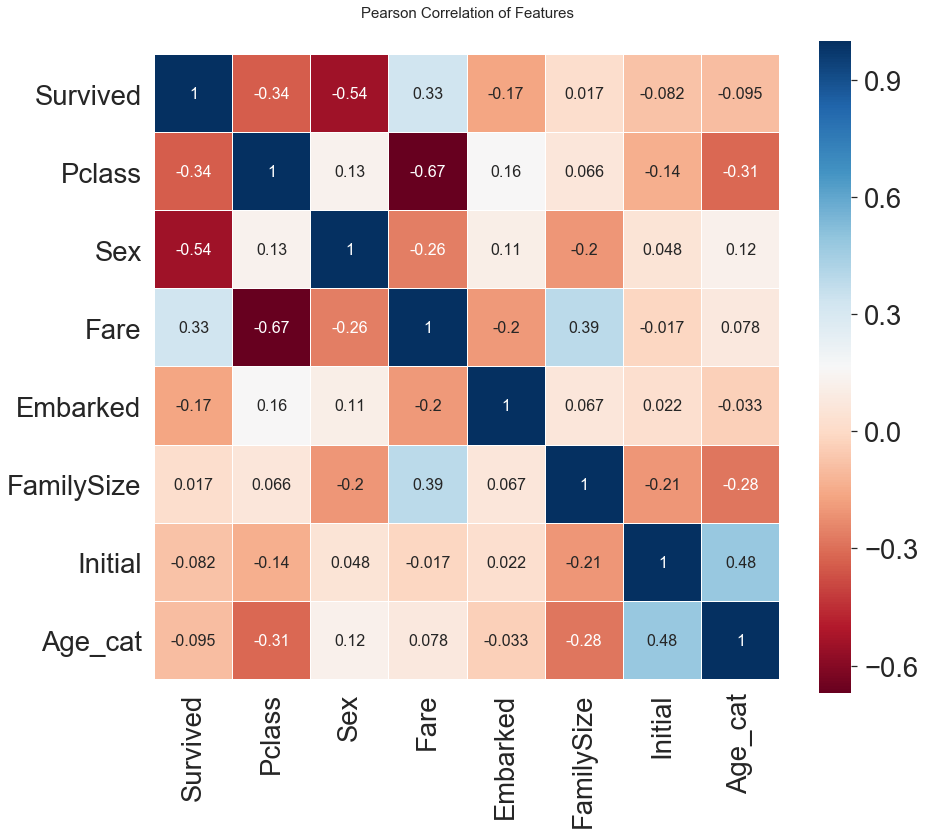

In [353]:
heatmap_data = df_train[['Survived', 'Pclass', 'Sex', 'Fare', 'Embarked', 'FamilySize', 'Initial', 'Age_cat']] 

colormap = plt.cm.RdBu
plt.figure(figsize=(14, 12))
plt.title('Pearson Correlation of Features', y=1.05, size=15)
sns.heatmap(heatmap_data.astype(float).corr(), linewidths=0.1, vmax=1.0,
           square=True, cmap=colormap, linecolor='white', annot=True, annot_kws={"size": 16})

del heatmap_data

 - EDA에서 살펴봤듯이, Sex 와 Pclass 가 Survived 에 상관관계가 어느 정도 있음을 볼 수 있습니다.
 - 생각보다 fare 와 Embarked 도 상관관계가 있음을 볼 수 있습니다.
 - 또한 우리가 여기서 얻을 수 있는 정보는 서로 강한 상관관계를 가지는 feature들이 없다는 것ㅇ비니다.
 - 이것은 우리가 모델을 학습시킬 때, 불필요한(redundant, superfluous) feature 가 없다는 것을 의미합니다. 1 또는 -1의 상관관계를 가진 feature A, B가 있다면, 우리가 얻을 수 있는 정보는 사실 한개입니다
 - 이제 실제로 모델을 학습시키기 앞서서 data preprocessing(전처리)을 진행해보겠습니다. 

<h3> One-hot encoding on Initial and Embarked </h3>

 - 수치화시킨 카테고리 데이터를 그대로 넣어도 되지만, 모델의 성능을 높이기 위해 one-hot encoding 을 해줄 수 있습니다.
 - 수치화는 간단히 Master == 0, Miss == 1, Mr == 2, Mrs == 3, Other == 4 로 매핑해주는 것을 말합니다
 - One-hot encoding 은 위 카테고리를 아래와 같이 (0,1)로 이루어진 5차원 벡터로 나타내는 것을 말합니다.
 
 
 
  - 총 5개의 카테고리니, one-hot encoding 을 하고 나면 새로운 5개의 column이 생겨납니다.
  - Initial 을 prefix로 두어서 구분이 쉽게 만들어 줍니다.

In [354]:
df_train = pd.get_dummies(df_train, columns=['Initial'], prefix='Initial')
df_test = pd.get_dummies(df_test, columns=['Initial'], prefix='Initial')

In [355]:
df_train.head()

,PassengerId,Survived,Pclass,Name,Sex,SibSp,Parch,Ticket,Fare,Cabin,Embarked,FamilySize,Age_cat,Initial_0.0,Initial_1.0,Initial_2.0,Initial_3.0,Initial_4.0
0,1,0,3,"Braund, Mr. Owen Harris",1,1,0,A/5 21171,1.981001,NaN,2,2,2,0,0,1,0,0
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,1,0,PC 17599,4.266662,C85,0,2,3,0,0,0,1,0
2,3,1,3,"Heikkinen, Miss. Laina",0,0,0,STON/O2. 3101282,2.070022,NaN,2,1,2,0,1,0,0,0
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,1,0,113803,3.972177,C123,2,2,3,0,0,0,1,0
4,5,0,3,"Allen, Mr. William Henry",1,0,0,373450,2.085672,NaN,2,1,3,0,0,1,0,0


 - 보시다시피 오른쪽에 우리가 만들려고 했던 one-hot encoded columns가 생선된 것이 보입니다.
 
 - Embarked 에도 적용하겠습니다. Initial 때와 마찬가지로 one-hot encoding 을 사용해 표현하겠습니다.

In [356]:
df_train = pd.get_dummies(df_train, columns=['Embarked'], prefix='embarked')
df_test = pd.get_dummies(df_test, columns=['Embarked'], prefix='embarked')

 - 아주 쉽게 one-hot encoding 을 적용했습니다.
 - sklearn 로 Labelencoder + OneHotencoder 이용해도 one-hot encoding 이 가능합니다.
 - 가끔 category 가 100개가 넘어가는 경우가 있는데, 이때 one-hot encoding을 사용하면 column이 100개가 생겨 학습시 매우 버거울수가 있습니다. 이런경우는 다른방법을 사용하시는 것을 추천드립니다.

<h3> 3.5 Drop columns </h3>

 - 이제 필요한 columns 만 남기고 다 지워주겠습니다.

In [357]:
df_train.drop(['PassengerId', 'Name', 'SibSp', 'Parch', 'Ticket', 'Cabin'], axis=1, inplace = True)
df_test.drop(['PassengerId', 'Name', 'SibSp', 'Parch', 'Ticket', 'Cabin'], axis=1, inplace = True)

In [358]:
df_train.head()

,Survived,Pclass,Sex,Fare,FamilySize,Age_cat,Initial_0.0,Initial_1.0,Initial_2.0,Initial_3.0,Initial_4.0,embarked_0,embarked_1,embarked_2
0,0,3,1,1.981001,2,2,0,0,1,0,0,0,0,1
1,1,1,0,4.266662,2,3,0,0,0,1,0,1,0,0
2,1,3,0,2.070022,1,2,0,1,0,0,0,0,0,1
3,1,1,0,3.972177,2,3,0,0,0,1,0,0,0,1
4,0,3,1,2.085672,1,3,0,0,1,0,0,0,0,1


In [359]:
df_test.head()

,Pclass,Sex,Fare,FamilySize,Age_cat,embarked_0,embarked_1,embarked_2
0,3,1,2.057860,1,3,0,1,0
1,3,0,1.945910,2,4,0,0,1
2,2,1,2.270836,1,6,0,1,0
3,3,1,2.159003,1,2,0,0,1
4,3,0,2.508582,3,2,0,0,1


 - train의 Survived(target class)를 빼면 train, test 둘다 같은 columns 를 가진 걸 확인할 수 있습니다.

<h2> 4 Building machine learning model and prediction using the trained model </h2>

 - 이제 준비가 다 되었으니 sklearn 을 사용해 본격적으로 머신러닝 모델을 만들겠습니다.

In [360]:
#importing all the required ML packages

from sklearn.ensemble import RandomForestClassifier #유명한 randomforestclassifier 
from sklearn import metrics #모델의 평가를 위해서 사용
from sklearn.model_selection import train_test_split #traning set을 쉽게 나눠주는 함수

 - Sklearn 은 머신러닝의 처음부터 끝까지 다 있습니다. feature engineering, preprocessing, 지도학습 알고리즘, 비지도학습 알고리즘, 모델평가, 파이프라인 등 머신러닝에 관련된 모든 작업들이 손쉬운 인터페이스로 구현되어 있습니다. 데이터 분석 + 머신러닝을 하고싶다면, 이 라이브러리는 반드시 숙지해야 합니다.
 - 지금 타이타닉 문제는 target class(survived)가 있으며, target class는 0,1로 이루어져 있으므로, (binary) binary classfication 문제입니다.
 - 우리가 지금 가지고 있는 train set 의 survived를 제외한 input 을 가지고 모델을 최적화시켜서 샘플(탑승객)의 생존유무를 판단하는 모델을 만들어 냅니다.
 - 그 후 모델이 학습하지 않았던 test set 을 input 으로 주어서 test set 의 각 샘플(탑승객)의 생존 유무를 예측해봅니다
 
 
 
 <h3> 4.1 Preparation - Split dataset into train, vaild, testset</h3>
    
 - 가장 먼저, 학습에 쓰일 데이터와, target label(Survived)를 분리합니다. drop을 사용해 간단히 할 수 있습니다

In [361]:
X_train = df_train.drop('Survived', axis=1).values
target_label = df_train['Survived'].values
X_test = df_test.values

 - 보통 train, test 만 언급되지만, 실제 좋은 모델을 만들기 위해서는 우리는 valid set을 따로 만들어 모델 평가를 해봅니다.
 - 마치 축구대표팀이 팀훈련(train)을 하고 바로 월드컵(test)로 나가는 것이 아니라, 팀훈련(train)을 한 다음 평가전(valid)를 거쳐 팀의 훈련 정도(학습정도)를 확인하고 월드컵(test)에 나가는 것과 비슷합니다.
 - train_test_split 을 사용하여 쉽게 train 셋을 분리할 수 있습니다.

In [362]:
X_tr, X_vld, y_tr, y_vld = train_test_split(X_train, target_label, test_size=0.3, random_state=2018)

 - sklearn 에서는 여러 머신러닝 알고리즘을 지원해줍니다. 열거하기엔 너무 많으므로, 직접 documentation에 들어가보는 것을 추천합니다.
 - 본 학습에서는 랜덤포레스트 모델을 사용하도록 하겠습니다.
 - 랜덤포레스트는 결정트리기반 모델이며, 여러 결정 트리들을 앙상블한 모델입니다. 
 - 각 머신러닝 알고리즘에는 여러 파라미터들이 있는데, 랜덤포레스트분류기도 n_estimators, max_features, max_depth, min_samples_split, min_samples_leaf 등 여러 파라미터들이 존재합니다. 이것들이 어떻게 세팅되냐에 따라 같은 데이터셋이라 하더라도 모델의 성능이 달라집니다.
 - 파라미터 튜닝은 시간, 경험, 알고리즘에 대한 이해 등이 필요합니다. 결국 많이 써봐야 모델도 잘 세울수 있습니다.
 - 모델 객체를 만들고 fit 메소드로 학습시킵니다.
 - 그런후 valid set input 을 넣어주어 예측값 (X_vld sample(탑승객)의 생존여부)를 얻습니다.
 
 
 
 <h3> 4.2 Model generation and prediction </h3>

In [363]:
model = RandomForestClassifier()
model.fit(X_tr, y_tr)
prediction = model.predict(X_vld)

In [364]:
print('총 {}명 중 {:.2f}% 정확도로 생존을 맞춤'.format(y_vld.shape[0], 100 * metrics.accuracy_score(prediction, y_vld)))

총 268명 중 82.09% 정확도로 생존을 맞춤
